<a href="https://colab.research.google.com/github/siddharth3444/detect_window/blob/main/Model_Training_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets -qq
!pip install evaluate -qq
!pip install albumentations -qq
!pip install git+https://github.com/huggingface/transformers.git -qq
# We will use this to push our trained model to HF Hub
!pip install huggingface_hub -qq

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [5]:
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import albumentations as A
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import (
    MaskFormerConfig,
    MaskFormerImageProcessor,
    MaskFormerModel,
    MaskFormerForInstanceSegmentation,
)
import evaluate
from huggingface_hub import notebook_login

In [6]:
from datasets import load_dataset
train = load_dataset("scene_parse_150", "instance_segmentation", split="train[:20]")
validation = load_dataset("scene_parse_150", "instance_segmentation", split="validation[:5]")
test = load_dataset("scene_parse_150", "instance_segmentation", split="test[:5]")

In [7]:
checkpoint = "facebook/maskformer-swin-tiny-ade"

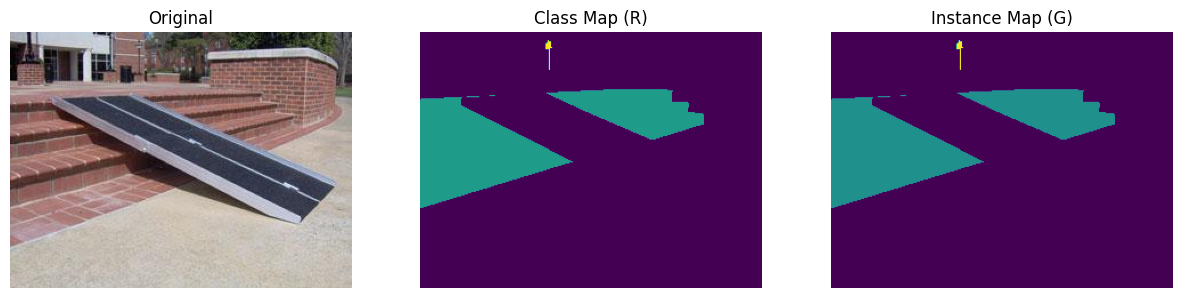

In [8]:
index = random.randint(0, len(train))
image = train[index]["image"]
image = np.array(image.convert("RGB"))
annotation = train[index]["annotation"]
annotation = np.array(annotation)
plt.figure(figsize=(15, 5))
for plot_index in range(3):
    if plot_index == 0:
        # If plot index is 0 display the original image
        plot_image = image
        title = "Original"
    else:
        # Else plot the annotation maps
        plot_image = annotation[..., plot_index - 1]
        title = ["Class Map (R)", "Instance Map (G)"][plot_index - 1]
    # Plot the image
    plt.subplot(1, 3, plot_index + 1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis("off")

In [26]:
from transformers import MaskFormerFeatureExtractor
processor = MaskFormerFeatureExtractor.from_pretrained(checkpoint)
processor = MaskFormerImageProcessor(
    reduce_labels=True,
    size=(512, 512),
    ignore_index=255,
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
)

print(processor)
#print(processor1)

MaskFormerImageProcessor {
  "_max_size": 1333,
  "do_normalize": false,
  "do_reduce_labels": true,
  "do_rescale": false,
  "do_resize": false,
  "ignore_index": 255,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "MaskFormerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  },
  "size_divisor": 32
}



/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:428: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [27]:
from transformers import MaskFormerConfig
config = MaskFormerConfig.from_pretrained(checkpoint)

In [28]:
model = MaskFormerForInstanceSegmentation(config)
# Replace the randomly initialized model with the pre-trained model weights
base_model = MaskFormerModel.from_pretrained(checkpoint)
model.model = base_model

In [29]:
!wget https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt
# Get a modified version of the id2label and label2id
data = pd.read_csv(
    "/content/instanceInfo100_train.txt",
    sep="\t",
    header=0,
    on_bad_lines="skip",
)
id2label = {id: label.strip() for id, label in enumerate(data["Object Names"])}
label2id = {v: k for k, v in id2label.items()}
# Edit MaskFormer config labels
config.id2label = id2label
config.label2id = label2id

--2024-01-13 08:46:55--  https://raw.githubusercontent.com/CSAILVision/placeschallenge/master/instancesegmentation/instanceInfo100_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3313 (3.2K) [text/plain]
Saving to: ‘instanceInfo100_train.txt.2’

instanceInfo100_tra 100%[===================>]   3.24K  --.-KB/s    in 0s      

2024-01-13 08:46:55 (23.8 MB/s) - ‘instanceInfo100_train.txt.2’ saved [3313/3313]



In [30]:
# Define the configurations of the transforms specific
# to the dataset used
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255
# Build the augmentation transforms
train_val_transform = A.Compose([
    A.Resize(width=512, height=512),
    A.HorizontalFlip(p=0.3),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# print(train[0]["annotation"])

# image = np.array(train[1]["image"].convert("RGB"))
# instance_seg = np.array(train[1]["annotation"])[..., 1]
# class_id_map = np.array(train[1]["annotation"])[..., 0]
# class_labels = np.unique(class_id_map)

# print(instance_seg)
# print(class_id_map)
# print(class_labels)
# inst2class = {}

# for label in class_labels:
#       instance_ids = np.unique(instance_seg[class_id_map == label])
#       inst2class.update({i: label for i in instance_ids})
# print(inst2class)

# transformed = train_val_transform(image=image, mask=instance_seg)
# # print(transformed)
# (image, instance_seg) = (transformed["image"], transformed["mask"])

# # print((image, instance_seg))

# # # Convert from channels last to channels first
# # image = image.transpose(2,0,1)

# inputs = processor([image], return_tensors="pt")
# inputs = {k:v.squeeze() for k,v in inputs.items()}
# inputs["class_labels"] = torch.tensor([0])
# inputs["mask_labels"] = torch.zeros(
#     (0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1])
# )

class ImageSegmentationDataset(Dataset):
    def __init__(self, dataset, processor, transform=None):
        # Initialize the dataset, processor, and transform variables
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        # Return the number of datapoints
        return len(self.dataset)

    def __getitem__(self, idx):
        # Convert the PIL Image to a NumPy array
        image = np.array(self.dataset[idx]["image"].convert("RGB"))

        # Get the pixel wise instance id and category id maps
        # of shape (height, width)
        instance_seg = np.array(self.dataset[idx]["annotation"])[..., 1]
        class_id_map = np.array(self.dataset[idx]["annotation"])[..., 0]
        class_labels = np.unique(class_id_map)
        # Build the instance to class dictionary
        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})
        # Apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            (image, instance_seg) = (transformed["image"], transformed["mask"])

            # Convert from channels last to channels first
            image = image.transpose(2,0,1)
        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # If the image has no objects then it is skipped
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros(
                (0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1])
            )
        else:
            # Else use process the image with the segmentation maps
            inputs = self.processor(
                [image],
                [instance_seg],
                instance_id_to_semantic_id=inst2class,
                return_tensors="pt"
            )
            inputs = {
                k:v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()
            }
        # Return the inputs
        return inputs
# Build the train and validation instance segmentation dataset
train_dataset = ImageSegmentationDataset(
    train,
    processor=processor,
    transform=train_val_transform
)
val_dataset = ImageSegmentationDataset(
    validation,
    processor=processor,
    transform=train_val_transform
)

In [31]:
inputs = val_dataset[0]
for k,v in inputs.items():
  print(k, v.shape)

pixel_values torch.Size([3, 512, 512])
pixel_mask torch.Size([512, 512])
mask_labels torch.Size([4, 512, 512])
class_labels torch.Size([4])


In [32]:
def collate_fn(examples):
    # Get the pixel values, pixel mask, mask labels, and class labels
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_mask = torch.stack([example["pixel_mask"] for example in examples])
    mask_labels = [example["mask_labels"] for example in examples]
    class_labels = [example["class_labels"] for example in examples]
    # Return a dictionary of all the collated features
    return {
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
        "mask_labels": mask_labels,
        "class_labels": class_labels
    }
# Building the training and validation dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)


In [1]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Initialize Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
# Set number of epochs and batch size
num_epochs = 2
for epoch in range(num_epochs):
    print(f"Epoch {epoch} | Training")
    # Set model in training mode
    model.train()
    train_loss, val_loss = [], []
    # Training loop
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # Reset the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
            class_labels=[labels.to(device) for labels in batch["class_labels"]],
        )
        # Backward propagation
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        if idx % 50 == 0:
            print("  Training loss: ", round(sum(train_loss)/len(train_loss), 6))
        # Optimization
        optimizer.step()
    # Average train epoch loss
    train_loss = sum(train_loss)/len(train_loss)
    # Set model in evaluation mode
    model.eval()
    start_idx = 0
    print(f"Epoch {epoch} | Validation")
    for idx, batch in enumerate(tqdm(val_dataloader)):
        with torch.no_grad():
            # Forward pass
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )
            # Get validation loss
            loss = outputs.loss
            val_loss.append(loss.item())
            if idx % 50 == 0:
                print("  Validation loss: ", round(sum(val_loss)/len(val_loss), 6))
    # Average validation epoch loss
    val_loss = sum(val_loss)/len(val_loss)
    # Print epoch losses
    print(f"Epoch {epoch} | train_loss: {train_loss} | validation_loss: {val_loss}")

NameError: name 'torch' is not defined

In [ ]:
model.save_pretrained("/content/models")
preprocessor.save_pretrained("/content/models")